In [4]:
import numpy as np
import os
from time import time
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
import seaborn as sns
import ipynb
sns.set(style="darkgrid")

In [5]:
from ipynb.fs.full.closed_form_solution import f, p, p1, p2, call_price

In [31]:
start = time()

# Set the constants
# -----------------------------------------------------------------------------------
r = 0
S0 = k = 2.0
t_max = 1.0
V0 = 0.010201
sigma = 0.61
mu =0.05
theta = 0.019
kappa = 6.21

rho = -0.5

n = 40 #400 # n time periods
m = n * n # number of simulations

Stock prices simulation:

In [32]:
def stock_price_generator (t_max, n ,m, r, S0, k, V0, sigma, theta, kappa, rho):
    dt = t_max / n
    
    # Brownian motions:
    dw_v = generator.normal(size=(m, n)) * np.sqrt(dt)
    dw_i = generator.normal(size=(m, n)) * np.sqrt(dt)

    dw_s = rho * dw_v + np.sqrt(1.0 - rho ** 2) * dw_i

    # Perform time evolution 
    s = np.empty((m, n + 1)) # initialisation stock prices vector
    s[:, 0] = S0

    v = np.ones(m) * V0

    for t in range(n):
        dv = kappa * (theta - v) * dt + sigma * np.sqrt(v) * dw_v[:, t]
        ds = r * s[:, t] * dt + np.sqrt(v) * s[:, t] * dw_s[:, t]

        v = np.clip(v + dv, a_min=0.0, a_max=None)
        s[:, t + 1] = s[:, t] + ds
        
        
    return s    
    

In [33]:
call_price(kappa, theta, sigma, rho, V0, r, t_max, S0 ,k)

0.1599385592500563

In [34]:
s = stock_price_generator (t_max, n ,m, r, S0, k, V0, sigma, theta, kappa, rho)

In [35]:
s

array([[2.        , 1.9881016 , 1.99044015, ..., 2.04461522, 2.03751363,
        2.11540135],
       [2.        , 2.01270783, 1.97606952, ..., 1.80629564, 1.81229864,
        1.82879963],
       [2.        , 2.00354635, 1.9593785 , ..., 1.83873974, 1.82831661,
        1.81784418],
       ...,
       [2.        , 2.01960321, 1.96074756, ..., 1.93180381, 1.98034881,
        1.96540326],
       [2.        , 1.98226706, 2.03313029, ..., 2.0583845 , 2.0246139 ,
        2.02388496],
       [2.        , 2.04661704, 2.05722764, ..., 2.27214231, 2.21426921,
        2.14522594]])

In [36]:
len(s)

1600

In [37]:
len(s[0])

41

In [38]:
# mean and standard deviatiom
expected_price = s[:, -1].mean()
price_std = s[:, -1].std()

price_error = price_std / np.sqrt(m) # error of monte carlo

Plots stock prices simulations:

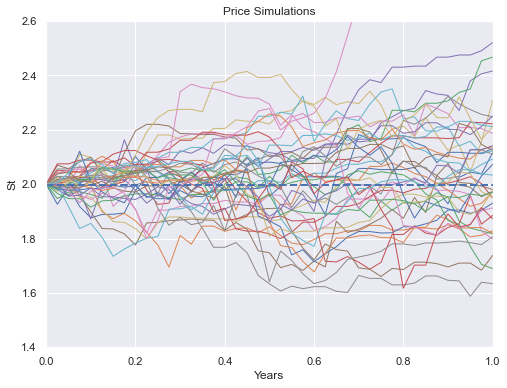

In [39]:
# Setup figure
plt.figure(figsize=(8,6))
# noinspection PyTypeChecker
ax_lines = plt.axes()

# Make the line plots
t = np.linspace(0, t_max, num=n + 1)
ns = 40
for i in range(ns):
    ax_lines.plot(t, s[i, :], lw=1.0)
ax_lines.set(xlabel='Years', ylabel='St',title='Price Simulations')
ax_lines.set_xlim((0, 1))
ax_lines.set_ylim((1.4, 2.6))

# Add mean value to line plots
ax_lines.plot([0.0, 1.0], [expected_price, expected_price], lw='2', ls="--", label='mean')
plt.show()
#plt.savefig("simulation.png")

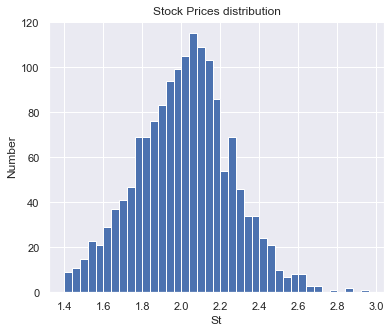

In [40]:
plt.figure(figsize=(6,5))
bins = np.arange(1.4, 3, .04)
plt.hist(s[:, -1], bins=bins)
plt.xlabel('St')
plt.ylabel('Number')
plt.title('Stock Prices distribution')
plt.show()

Payoff:

In [16]:
def find_expected_payoff(stock_path, k, r, t_max):
    payoff = max(stock_path[-1] - k, 0) # one payoff for each simulation
    c = payoff * np.exp(-r * t_max)     # in case r=0, this step is useless
    
    return c

In [17]:
payoff = []

for stock_path in s:
    payoff = np.append (payoff, find_expected_payoff(stock_path, k, r, t_max))
    

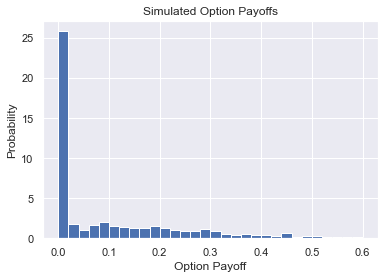

In [18]:
# Make the histogram for the Payoffs
plt.figure()
bins = np.arange(0, payoff.max() + 0.02, 0.02)
plt.hist(payoff, bins=np.arange(0.0, 0.62, 0.02), density=True)
plt.title("Simulated Option Payoffs")
plt.xlabel("Option Payoff")
plt.ylabel("Probability")
plt.savefig("payoffs.png")

In [19]:
# Calculate expected call option payoff and therefore option price
# -----------------------------------------------------------------------------------

payoff = np.clip(s[:, -1] - k, a_min=0, a_max=None) # one payoff for each simulation

expected_payoff = payoff.mean()
payoff_std = payoff.std()
payoff_error = payoff_std / np.sqrt(m)

In [20]:
c = expected_payoff * np.exp(-r * t_max) # in case r=0, this step is useless
c

0.10283299797482598